In [1]:
from data_processing.Datasets import get_maestro_dataset, collate_fn
from torch.utils.data import DataLoader
import torch
from model.transformer import Transformer
from functools import partial
import muspy
import copy

# NOTE: THIS DOWNLOADS SOMETHING, NEEDED TO GENERATE MUSIC WITH MUSPY
muspy.download_musescore_soundfont()


Skip downloading as the MuseScore General soundfont is found.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# training hyperparams
EPOCHS = 5
LEARNING_RATE = 0.01

# data hyperparams
SEQ_LEN = 700
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 10

# model hyperparams
NUM_TOKENS = 130
DIM_MODEL = 512
NUM_HEADS = 2
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT_P = 0.1

REPRESENTATION = "pitch"  # set to either 'event' or 'pitch'


In [4]:
# load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
train_data, test_data = get_maestro_dataset(
    "data/maestro", representation=REPRESENTATION
)


Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
Skip conversion as the `.muspy.success` file is found.


In [6]:
# Build dataloaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    collate_fn=partial(collate_fn, seq_len=SEQ_LEN, device=device),
    shuffle=False,
)

val_dataloader = DataLoader(
    dataset=test_data,
    batch_size=EVAL_BATCH_SIZE,
    collate_fn=partial(collate_fn, seq_len=SEQ_LEN, device=device),
    shuffle=False,
)


In [7]:
# create model, optim, criterion
model = Transformer(
    num_tokens=NUM_TOKENS,
    dim_model=DIM_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout_p=DROPOUT_P,
).to(device)


## Prepare Primer

This cell loads a small sample from the validation dataset that is passed into the transformer to be used as a baseline for generating more music.


torch.Size([256741, 1])
torch.Size([1500, 1])
torch.Size([1500, 1])


[<AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>]

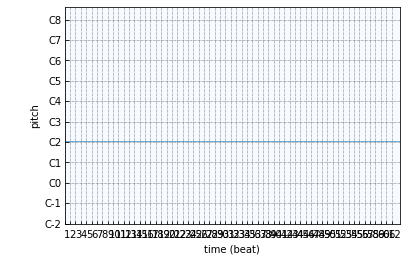

In [8]:
# prepare primer
primer = torch.tensor(test_data.dataset.__getitem__(1), dtype=torch.long)

labels = copy.deepcopy(primer)

print(primer.shape)

primer = primer[100:150]
print(primer.shape)
labels = labels[100:150]
print(labels.shape)

# display primer pianoroll
primer_arr = primer.clone().detach().numpy()

if REPRESENTATION == "pitch":
    music_primer = muspy.from_pitch_representation(primer_arr)
elif REPRESENTATION == "event":
    music_primer = muspy.from_event_representation(primer_arr)

muspy.show_pianoroll(music_primer)


In [9]:
# load saved model params
model.load_state_dict(torch.load("./results/transformer/model_params/model-pitch.pth"))

# set to test
model.eval()

# pass in primer
with torch.no_grad():
    data = model.generate(primer, device, labels, target_seq_length=1000)

# decode the returned info
data = data.detach().numpy()

if REPRESENTATION == "pitch":
    music = muspy.from_pitch_representation(data)
elif REPRESENTATION == "event":
    music = muspy.from_event_representation(data)
else:
    print(
        "Please use either event or pitch based representation, depending on what the model was trained on."
    )
    print("If you don't know what either of those are, set REPRESENTATION='event'")

muspy.write_audio("./results/transformer/music/test-pitch-short.wav", music, "wav")


Generating Sequence of length 4000, with an initial primer of length 1500


100%|██████████| 2500/2500 [38:05<00:00,  1.09it/s, length=4000]


## Visualize the music


[<AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>]

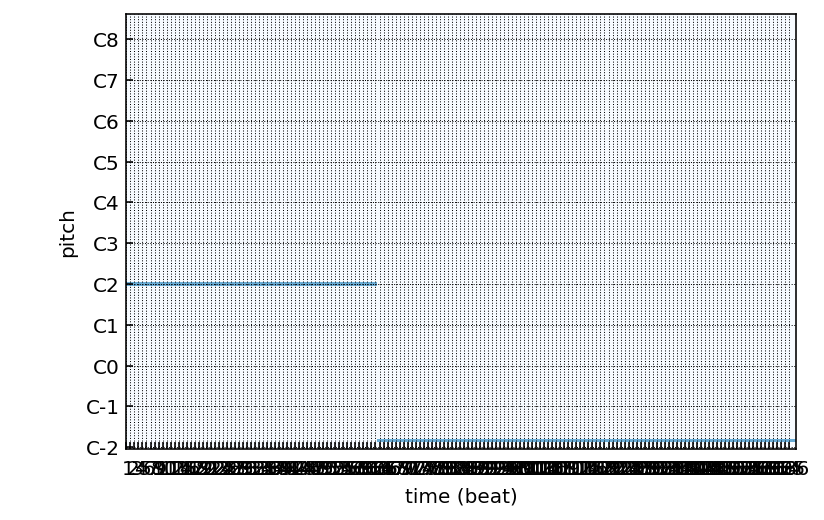

In [10]:
muspy.show_pianoroll(music)
